In [1]:
from __future__  import print_function, division

#import keras and tensorflow backend
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

#import for plotting and data preprocessing
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [0]:
#Create GAN class function
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        #Use the adam optimizer algorithm instead of gradient descent
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Instantiate the generator to self
        self.generator = self.build_generator()

        # Input noise into the generator to create new images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # Disable the discriminator from being trained
        self.discriminator.trainable = False

        # determine validity of the generated images
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

#build generator function
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

#build discriminator function
    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

#training function
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

#Train Discriminator

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#Train Generator
            #Create random noise 
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

#Show sample images
    def sample_images(self, epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.889931, acc.: 23.44%] [G loss: 0.835586]


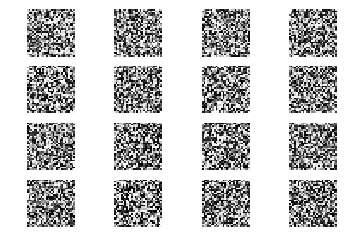

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.554137, acc.: 70.31%] [G loss: 0.754023]
2 [D loss: 0.375843, acc.: 76.56%] [G loss: 0.854939]
3 [D loss: 0.341846, acc.: 84.38%] [G loss: 0.952254]
4 [D loss: 0.296720, acc.: 84.38%] [G loss: 1.066850]
5 [D loss: 0.295679, acc.: 89.06%] [G loss: 1.190778]
6 [D loss: 0.230741, acc.: 95.31%] [G loss: 1.252168]
7 [D loss: 0.205122, acc.: 96.88%] [G loss: 1.295546]
8 [D loss: 0.231448, acc.: 96.88%] [G loss: 1.408656]
9 [D loss: 0.200220, acc.: 95.31%] [G loss: 1.561862]
10 [D loss: 0.185369, acc.: 98.44%] [G loss: 1.733566]
11 [D loss: 0.187882, acc.: 96.88%] [G loss: 1.899236]
12 [D loss: 0.146411, acc.: 96.88%] [G loss: 1.848012]
13 [D loss: 0.130899, acc.: 98.44%] [G loss: 2.004734]
14 [D loss: 0.098973, acc.: 100.00%] [G loss: 1.899603]
15 [D loss: 0.090000, acc.: 100.00%] [G loss: 2.076910]
16 [D loss: 0.090179, acc.: 100.00%] [G loss: 2.225305]
17 [D loss: 0.095200, acc.: 100.00%] [G loss: 2.116049]
18 [D loss: 0.094594, acc.: 100.00%] [G loss: 2.315227]
19 [D loss: 0.

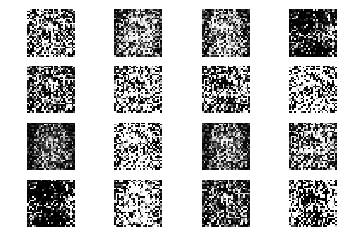

201 [D loss: 0.233255, acc.: 87.50%] [G loss: 3.593088]
202 [D loss: 0.245314, acc.: 93.75%] [G loss: 3.307954]
203 [D loss: 0.244433, acc.: 89.06%] [G loss: 3.546716]
204 [D loss: 0.256931, acc.: 90.62%] [G loss: 3.718716]
205 [D loss: 0.335606, acc.: 81.25%] [G loss: 3.353462]
206 [D loss: 0.330562, acc.: 79.69%] [G loss: 4.216368]
207 [D loss: 0.616067, acc.: 71.88%] [G loss: 3.338084]
208 [D loss: 0.150976, acc.: 93.75%] [G loss: 3.534900]
209 [D loss: 0.192283, acc.: 93.75%] [G loss: 2.919011]
210 [D loss: 0.263303, acc.: 85.94%] [G loss: 3.344397]
211 [D loss: 0.255494, acc.: 93.75%] [G loss: 3.374332]
212 [D loss: 0.445634, acc.: 78.12%] [G loss: 3.605068]
213 [D loss: 0.280064, acc.: 87.50%] [G loss: 3.548008]
214 [D loss: 0.540137, acc.: 70.31%] [G loss: 3.531588]
215 [D loss: 0.234879, acc.: 90.62%] [G loss: 3.430085]
216 [D loss: 0.376816, acc.: 81.25%] [G loss: 3.230792]
217 [D loss: 0.258545, acc.: 89.06%] [G loss: 3.625714]
218 [D loss: 0.328468, acc.: 87.50%] [G loss: 3.

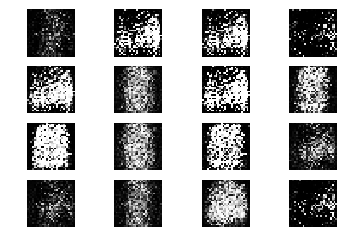

401 [D loss: 0.463789, acc.: 79.69%] [G loss: 2.371317]
402 [D loss: 0.617199, acc.: 71.88%] [G loss: 2.575898]
403 [D loss: 0.440734, acc.: 81.25%] [G loss: 2.200054]
404 [D loss: 0.402544, acc.: 82.81%] [G loss: 2.412398]
405 [D loss: 0.483679, acc.: 73.44%] [G loss: 2.798233]
406 [D loss: 0.438394, acc.: 87.50%] [G loss: 2.751361]
407 [D loss: 0.433012, acc.: 79.69%] [G loss: 2.431901]
408 [D loss: 0.393907, acc.: 84.38%] [G loss: 2.308937]
409 [D loss: 0.487876, acc.: 79.69%] [G loss: 3.094640]
410 [D loss: 0.715876, acc.: 64.06%] [G loss: 2.945718]
411 [D loss: 0.426810, acc.: 84.38%] [G loss: 2.287875]
412 [D loss: 0.506729, acc.: 76.56%] [G loss: 2.532235]
413 [D loss: 0.590466, acc.: 70.31%] [G loss: 2.782845]
414 [D loss: 0.312130, acc.: 90.62%] [G loss: 2.609095]
415 [D loss: 0.559721, acc.: 59.38%] [G loss: 2.533831]
416 [D loss: 0.470096, acc.: 85.94%] [G loss: 2.402754]
417 [D loss: 0.404966, acc.: 78.12%] [G loss: 2.774814]
418 [D loss: 0.421641, acc.: 81.25%] [G loss: 2.

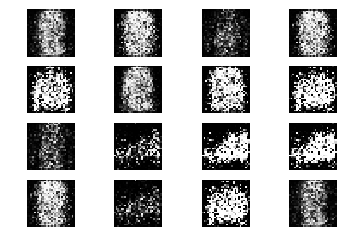

601 [D loss: 0.553115, acc.: 73.44%] [G loss: 1.539335]
602 [D loss: 0.525995, acc.: 76.56%] [G loss: 1.667769]
603 [D loss: 0.688066, acc.: 67.19%] [G loss: 1.269864]
604 [D loss: 0.659290, acc.: 56.25%] [G loss: 1.402815]
605 [D loss: 0.588742, acc.: 75.00%] [G loss: 1.711584]
606 [D loss: 0.618372, acc.: 81.25%] [G loss: 1.506648]
607 [D loss: 0.630249, acc.: 60.94%] [G loss: 1.501224]
608 [D loss: 0.724438, acc.: 48.44%] [G loss: 1.619839]
609 [D loss: 0.517968, acc.: 84.38%] [G loss: 1.612906]
610 [D loss: 0.633425, acc.: 75.00%] [G loss: 1.535143]
611 [D loss: 0.742819, acc.: 67.19%] [G loss: 1.315501]
612 [D loss: 0.727814, acc.: 51.56%] [G loss: 1.387690]
613 [D loss: 0.512079, acc.: 79.69%] [G loss: 1.467473]
614 [D loss: 0.542541, acc.: 73.44%] [G loss: 1.481958]
615 [D loss: 0.635910, acc.: 60.94%] [G loss: 1.451517]
616 [D loss: 0.668726, acc.: 64.06%] [G loss: 1.347523]
617 [D loss: 0.497892, acc.: 79.69%] [G loss: 1.597730]
618 [D loss: 0.699153, acc.: 57.81%] [G loss: 1.

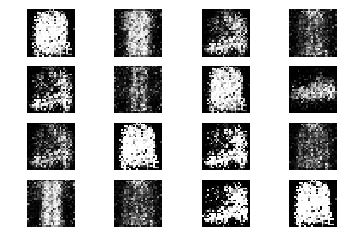

801 [D loss: 0.793075, acc.: 40.62%] [G loss: 1.041144]
802 [D loss: 0.781612, acc.: 43.75%] [G loss: 0.994728]
803 [D loss: 0.693264, acc.: 46.88%] [G loss: 0.997368]
804 [D loss: 0.664714, acc.: 62.50%] [G loss: 1.084106]
805 [D loss: 0.751182, acc.: 51.56%] [G loss: 0.929431]
806 [D loss: 0.668382, acc.: 62.50%] [G loss: 0.892607]
807 [D loss: 0.746198, acc.: 42.19%] [G loss: 0.907916]
808 [D loss: 0.642470, acc.: 54.69%] [G loss: 1.014964]
809 [D loss: 0.649590, acc.: 56.25%] [G loss: 1.155808]
810 [D loss: 0.805291, acc.: 48.44%] [G loss: 1.084526]
811 [D loss: 0.639549, acc.: 67.19%] [G loss: 0.985998]
812 [D loss: 0.713285, acc.: 51.56%] [G loss: 1.076986]
813 [D loss: 0.655007, acc.: 56.25%] [G loss: 1.156569]
814 [D loss: 0.755556, acc.: 48.44%] [G loss: 0.964497]
815 [D loss: 0.717440, acc.: 51.56%] [G loss: 0.914849]
816 [D loss: 0.673567, acc.: 53.12%] [G loss: 1.071357]
817 [D loss: 0.806298, acc.: 39.06%] [G loss: 0.924151]
818 [D loss: 0.777524, acc.: 54.69%] [G loss: 0.

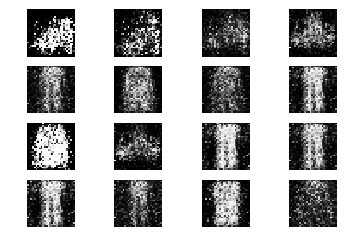

1001 [D loss: 0.638548, acc.: 70.31%] [G loss: 0.971741]
1002 [D loss: 0.606868, acc.: 65.62%] [G loss: 1.048094]
1003 [D loss: 0.611474, acc.: 62.50%] [G loss: 1.113518]
1004 [D loss: 0.580427, acc.: 75.00%] [G loss: 1.029504]
1005 [D loss: 0.638644, acc.: 65.62%] [G loss: 1.046441]
1006 [D loss: 0.663518, acc.: 57.81%] [G loss: 0.943851]
1007 [D loss: 0.642019, acc.: 59.38%] [G loss: 1.031898]
1008 [D loss: 0.683541, acc.: 57.81%] [G loss: 0.952668]
1009 [D loss: 0.664307, acc.: 60.94%] [G loss: 0.970747]
1010 [D loss: 0.697044, acc.: 48.44%] [G loss: 0.900816]
1011 [D loss: 0.666391, acc.: 60.94%] [G loss: 0.920251]
1012 [D loss: 0.682851, acc.: 59.38%] [G loss: 0.886572]
1013 [D loss: 0.741991, acc.: 50.00%] [G loss: 0.924424]
1014 [D loss: 0.608847, acc.: 67.19%] [G loss: 1.006840]
1015 [D loss: 0.649364, acc.: 70.31%] [G loss: 1.097332]
1016 [D loss: 0.626817, acc.: 67.19%] [G loss: 1.040382]
1017 [D loss: 0.617294, acc.: 67.19%] [G loss: 0.995314]
1018 [D loss: 0.633753, acc.: 6

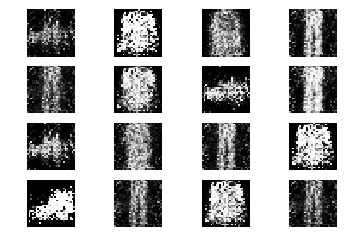

1201 [D loss: 0.650507, acc.: 54.69%] [G loss: 0.982147]
1202 [D loss: 0.644856, acc.: 62.50%] [G loss: 1.015341]
1203 [D loss: 0.661341, acc.: 62.50%] [G loss: 0.889846]
1204 [D loss: 0.650227, acc.: 51.56%] [G loss: 0.879523]
1205 [D loss: 0.641147, acc.: 64.06%] [G loss: 1.009495]
1206 [D loss: 0.682322, acc.: 59.38%] [G loss: 0.922576]
1207 [D loss: 0.649155, acc.: 64.06%] [G loss: 1.038589]
1208 [D loss: 0.633145, acc.: 60.94%] [G loss: 0.936030]
1209 [D loss: 0.677204, acc.: 67.19%] [G loss: 0.945182]
1210 [D loss: 0.681595, acc.: 62.50%] [G loss: 0.875594]
1211 [D loss: 0.657475, acc.: 54.69%] [G loss: 0.923418]
1212 [D loss: 0.656678, acc.: 64.06%] [G loss: 0.925706]
1213 [D loss: 0.671714, acc.: 54.69%] [G loss: 0.915467]
1214 [D loss: 0.727178, acc.: 48.44%] [G loss: 0.944292]
1215 [D loss: 0.674381, acc.: 56.25%] [G loss: 0.895145]
1216 [D loss: 0.745366, acc.: 45.31%] [G loss: 0.915447]
1217 [D loss: 0.664408, acc.: 62.50%] [G loss: 0.958469]
1218 [D loss: 0.683556, acc.: 5

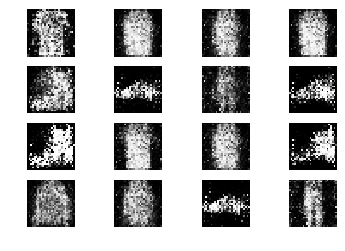

1401 [D loss: 0.655572, acc.: 60.94%] [G loss: 0.782752]
1402 [D loss: 0.677604, acc.: 56.25%] [G loss: 0.825138]
1403 [D loss: 0.648994, acc.: 65.62%] [G loss: 0.865672]
1404 [D loss: 0.602134, acc.: 70.31%] [G loss: 0.977202]
1405 [D loss: 0.687973, acc.: 51.56%] [G loss: 0.869387]
1406 [D loss: 0.750727, acc.: 39.06%] [G loss: 0.861355]
1407 [D loss: 0.683491, acc.: 54.69%] [G loss: 0.898251]
1408 [D loss: 0.675091, acc.: 56.25%] [G loss: 0.782179]
1409 [D loss: 0.658642, acc.: 56.25%] [G loss: 0.834840]
1410 [D loss: 0.608107, acc.: 59.38%] [G loss: 0.931459]
1411 [D loss: 0.667451, acc.: 62.50%] [G loss: 0.789220]
1412 [D loss: 0.746037, acc.: 54.69%] [G loss: 0.877008]
1413 [D loss: 0.729419, acc.: 46.88%] [G loss: 0.872212]
1414 [D loss: 0.719654, acc.: 48.44%] [G loss: 0.792071]
1415 [D loss: 0.715697, acc.: 45.31%] [G loss: 0.748414]
1416 [D loss: 0.685998, acc.: 50.00%] [G loss: 0.898005]
1417 [D loss: 0.710563, acc.: 50.00%] [G loss: 0.915824]
1418 [D loss: 0.704211, acc.: 4

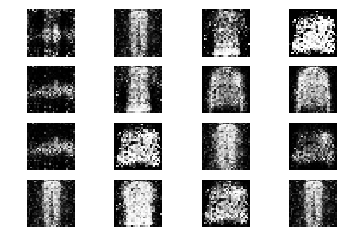

1601 [D loss: 0.724152, acc.: 50.00%] [G loss: 0.891642]
1602 [D loss: 0.709312, acc.: 45.31%] [G loss: 0.850506]
1603 [D loss: 0.673344, acc.: 59.38%] [G loss: 0.866366]
1604 [D loss: 0.745055, acc.: 43.75%] [G loss: 0.865695]
1605 [D loss: 0.716758, acc.: 53.12%] [G loss: 0.796658]
1606 [D loss: 0.689246, acc.: 51.56%] [G loss: 0.824978]
1607 [D loss: 0.656982, acc.: 57.81%] [G loss: 0.858362]
1608 [D loss: 0.702382, acc.: 54.69%] [G loss: 0.857505]
1609 [D loss: 0.718273, acc.: 48.44%] [G loss: 0.830004]
1610 [D loss: 0.610169, acc.: 62.50%] [G loss: 0.859553]
1611 [D loss: 0.739577, acc.: 40.62%] [G loss: 0.903493]
1612 [D loss: 0.677711, acc.: 53.12%] [G loss: 0.906949]
1613 [D loss: 0.682595, acc.: 51.56%] [G loss: 0.952940]
1614 [D loss: 0.656087, acc.: 70.31%] [G loss: 0.920781]
1615 [D loss: 0.640652, acc.: 71.88%] [G loss: 0.932963]
1616 [D loss: 0.658546, acc.: 71.88%] [G loss: 0.850078]
1617 [D loss: 0.617613, acc.: 65.62%] [G loss: 0.886577]
1618 [D loss: 0.680789, acc.: 5

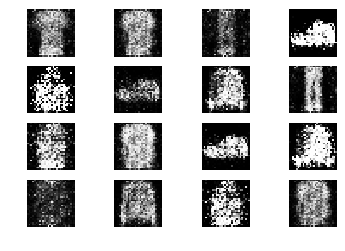

1801 [D loss: 0.635937, acc.: 64.06%] [G loss: 0.908752]
1802 [D loss: 0.727915, acc.: 46.88%] [G loss: 0.868193]
1803 [D loss: 0.697152, acc.: 51.56%] [G loss: 0.895598]
1804 [D loss: 0.747542, acc.: 45.31%] [G loss: 0.871243]
1805 [D loss: 0.709596, acc.: 50.00%] [G loss: 0.837273]
1806 [D loss: 0.687929, acc.: 45.31%] [G loss: 0.938845]
1807 [D loss: 0.676510, acc.: 64.06%] [G loss: 0.877548]
1808 [D loss: 0.652186, acc.: 64.06%] [G loss: 0.953523]
1809 [D loss: 0.629036, acc.: 71.88%] [G loss: 0.874780]
1810 [D loss: 0.607421, acc.: 68.75%] [G loss: 0.865510]
1811 [D loss: 0.646028, acc.: 70.31%] [G loss: 0.802888]
1812 [D loss: 0.640022, acc.: 60.94%] [G loss: 0.905147]
1813 [D loss: 0.691836, acc.: 57.81%] [G loss: 0.850824]
1814 [D loss: 0.671399, acc.: 64.06%] [G loss: 0.834175]
1815 [D loss: 0.635868, acc.: 56.25%] [G loss: 0.845176]
1816 [D loss: 0.673163, acc.: 50.00%] [G loss: 0.902922]
1817 [D loss: 0.681991, acc.: 53.12%] [G loss: 0.886792]
1818 [D loss: 0.686972, acc.: 5

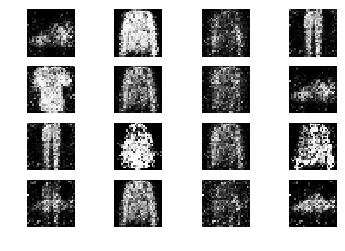

2001 [D loss: 0.700126, acc.: 45.31%] [G loss: 0.876582]
2002 [D loss: 0.700768, acc.: 54.69%] [G loss: 0.807190]
2003 [D loss: 0.635959, acc.: 65.62%] [G loss: 0.866805]
2004 [D loss: 0.740424, acc.: 56.25%] [G loss: 0.799567]
2005 [D loss: 0.729561, acc.: 48.44%] [G loss: 0.928060]
2006 [D loss: 0.706930, acc.: 51.56%] [G loss: 0.821663]
2007 [D loss: 0.685471, acc.: 53.12%] [G loss: 0.829795]
2008 [D loss: 0.773101, acc.: 43.75%] [G loss: 0.817733]
2009 [D loss: 0.686867, acc.: 62.50%] [G loss: 0.844396]
2010 [D loss: 0.717457, acc.: 53.12%] [G loss: 0.914965]
2011 [D loss: 0.664981, acc.: 59.38%] [G loss: 0.937286]
2012 [D loss: 0.626164, acc.: 64.06%] [G loss: 0.971732]
2013 [D loss: 0.654626, acc.: 53.12%] [G loss: 0.974210]
2014 [D loss: 0.631748, acc.: 62.50%] [G loss: 0.983418]
2015 [D loss: 0.633162, acc.: 65.62%] [G loss: 0.969349]
2016 [D loss: 0.687989, acc.: 54.69%] [G loss: 0.911905]
2017 [D loss: 0.660687, acc.: 64.06%] [G loss: 0.944203]
2018 [D loss: 0.692880, acc.: 5

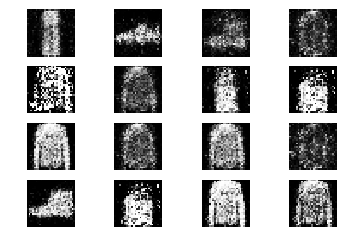

2201 [D loss: 0.647993, acc.: 56.25%] [G loss: 0.839404]
2202 [D loss: 0.639732, acc.: 62.50%] [G loss: 0.960690]
2203 [D loss: 0.657333, acc.: 64.06%] [G loss: 0.827543]
2204 [D loss: 0.655950, acc.: 59.38%] [G loss: 0.868804]
2205 [D loss: 0.663803, acc.: 57.81%] [G loss: 0.868477]
2206 [D loss: 0.559274, acc.: 70.31%] [G loss: 0.998902]
2207 [D loss: 0.665824, acc.: 65.62%] [G loss: 0.843243]
2208 [D loss: 0.650524, acc.: 62.50%] [G loss: 0.914110]
2209 [D loss: 0.675262, acc.: 54.69%] [G loss: 0.935784]
2210 [D loss: 0.648437, acc.: 56.25%] [G loss: 0.950556]
2211 [D loss: 0.663659, acc.: 60.94%] [G loss: 0.906612]
2212 [D loss: 0.739079, acc.: 51.56%] [G loss: 0.882853]
2213 [D loss: 0.638332, acc.: 65.62%] [G loss: 0.869718]
2214 [D loss: 0.647323, acc.: 57.81%] [G loss: 0.899348]
2215 [D loss: 0.654127, acc.: 60.94%] [G loss: 0.854815]
2216 [D loss: 0.823933, acc.: 40.62%] [G loss: 0.929359]
2217 [D loss: 0.692534, acc.: 51.56%] [G loss: 0.925198]
2218 [D loss: 0.716694, acc.: 5

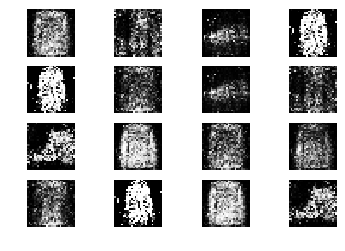

2401 [D loss: 0.618666, acc.: 67.19%] [G loss: 1.023506]
2402 [D loss: 0.640414, acc.: 54.69%] [G loss: 1.027330]
2403 [D loss: 0.649005, acc.: 59.38%] [G loss: 0.985036]
2404 [D loss: 0.592709, acc.: 64.06%] [G loss: 0.977056]
2405 [D loss: 0.663641, acc.: 56.25%] [G loss: 0.992811]
2406 [D loss: 0.644957, acc.: 65.62%] [G loss: 0.996074]
2407 [D loss: 0.633791, acc.: 70.31%] [G loss: 1.012325]
2408 [D loss: 0.720692, acc.: 48.44%] [G loss: 0.926180]
2409 [D loss: 0.631068, acc.: 57.81%] [G loss: 0.910163]
2410 [D loss: 0.592047, acc.: 62.50%] [G loss: 0.907927]
2411 [D loss: 0.570667, acc.: 71.88%] [G loss: 0.916219]
2412 [D loss: 0.755430, acc.: 54.69%] [G loss: 0.893065]
2413 [D loss: 0.596398, acc.: 65.62%] [G loss: 1.021580]
2414 [D loss: 0.549476, acc.: 76.56%] [G loss: 0.986743]
2415 [D loss: 0.588003, acc.: 68.75%] [G loss: 1.060164]
2416 [D loss: 0.687518, acc.: 59.38%] [G loss: 0.976953]
2417 [D loss: 0.630498, acc.: 71.88%] [G loss: 0.927547]
2418 [D loss: 0.575175, acc.: 7

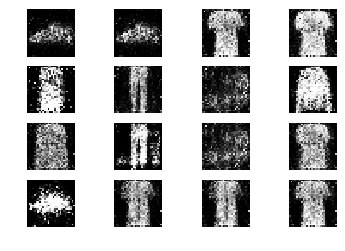

2601 [D loss: 0.683915, acc.: 57.81%] [G loss: 0.945723]
2602 [D loss: 0.656718, acc.: 56.25%] [G loss: 0.942268]
2603 [D loss: 0.680305, acc.: 60.94%] [G loss: 0.919541]
2604 [D loss: 0.641845, acc.: 62.50%] [G loss: 0.931151]
2605 [D loss: 0.661839, acc.: 54.69%] [G loss: 0.886267]
2606 [D loss: 0.726177, acc.: 39.06%] [G loss: 0.809369]
2607 [D loss: 0.711033, acc.: 42.19%] [G loss: 0.826654]
2608 [D loss: 0.754465, acc.: 37.50%] [G loss: 0.823913]
2609 [D loss: 0.695407, acc.: 56.25%] [G loss: 0.812405]
2610 [D loss: 0.618092, acc.: 65.62%] [G loss: 0.916948]
2611 [D loss: 0.640358, acc.: 59.38%] [G loss: 0.870524]
2612 [D loss: 0.598595, acc.: 68.75%] [G loss: 1.014488]
2613 [D loss: 0.625500, acc.: 60.94%] [G loss: 0.938270]
2614 [D loss: 0.706370, acc.: 53.12%] [G loss: 0.891502]
2615 [D loss: 0.639328, acc.: 65.62%] [G loss: 0.973261]
2616 [D loss: 0.688139, acc.: 57.81%] [G loss: 0.903044]
2617 [D loss: 0.705058, acc.: 50.00%] [G loss: 0.905404]
2618 [D loss: 0.732647, acc.: 4

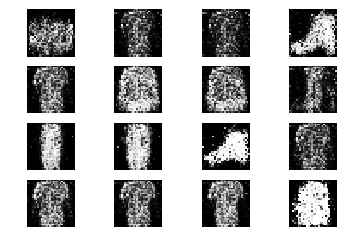

2801 [D loss: 0.689879, acc.: 62.50%] [G loss: 1.002849]
2802 [D loss: 0.649995, acc.: 57.81%] [G loss: 0.928026]
2803 [D loss: 0.641339, acc.: 62.50%] [G loss: 0.939846]
2804 [D loss: 0.703695, acc.: 60.94%] [G loss: 0.980149]
2805 [D loss: 0.614339, acc.: 68.75%] [G loss: 0.974475]
2806 [D loss: 0.617072, acc.: 67.19%] [G loss: 0.961285]
2807 [D loss: 0.658032, acc.: 51.56%] [G loss: 0.940387]
2808 [D loss: 0.669394, acc.: 56.25%] [G loss: 0.863006]
2809 [D loss: 0.603726, acc.: 65.62%] [G loss: 0.848057]
2810 [D loss: 0.766248, acc.: 42.19%] [G loss: 0.868003]
2811 [D loss: 0.616203, acc.: 62.50%] [G loss: 0.842083]
2812 [D loss: 0.695236, acc.: 53.12%] [G loss: 0.858605]
2813 [D loss: 0.678407, acc.: 59.38%] [G loss: 0.893609]
2814 [D loss: 0.676965, acc.: 60.94%] [G loss: 0.949504]
2815 [D loss: 0.697515, acc.: 60.94%] [G loss: 1.005015]
2816 [D loss: 0.689391, acc.: 51.56%] [G loss: 0.992930]
2817 [D loss: 0.739782, acc.: 50.00%] [G loss: 0.867137]
2818 [D loss: 0.681756, acc.: 4

In [3]:
# instantiate model and train
gan = GAN()
gan.train(epochs=3000, batch_size=32, sample_interval=200)